<a href="https://colab.research.google.com/github/Dau2004/Child-Malnutrition-Classification/blob/main/Summative_Assignment_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malnutrition Classification Project
# Optimizing Models for Child Malnutrition Detection

In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load dataset
df = pd.read_csv('/content/malnutrition_data (1).csv')

# Display dataset info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset Info:
Shape: (5000, 6)

First 5 rows:


,age_months,weight_kg,height_cm,muac_cm,bmi,nutrition_status
0,12.345052,3.000000,54.134002,13.160919,10.0,normal
1,30.807200,5.459076,76.199180,13.944380,10.0,normal
2,15.723226,3.000000,60.280820,13.243565,10.0,normal
3,57.796256,10.103074,104.990471,14.105683,10.0,normal
4,40.321320,7.110583,85.277902,14.641630,10.0,normal


In [ ]:
# Class distribution
print("\nClass Distribution:")
print(df['nutrition_status'].value_counts())


Class Distribution:
nutrition_status
normal      3550
moderate    1100
severe       350
Name: count, dtype: int64


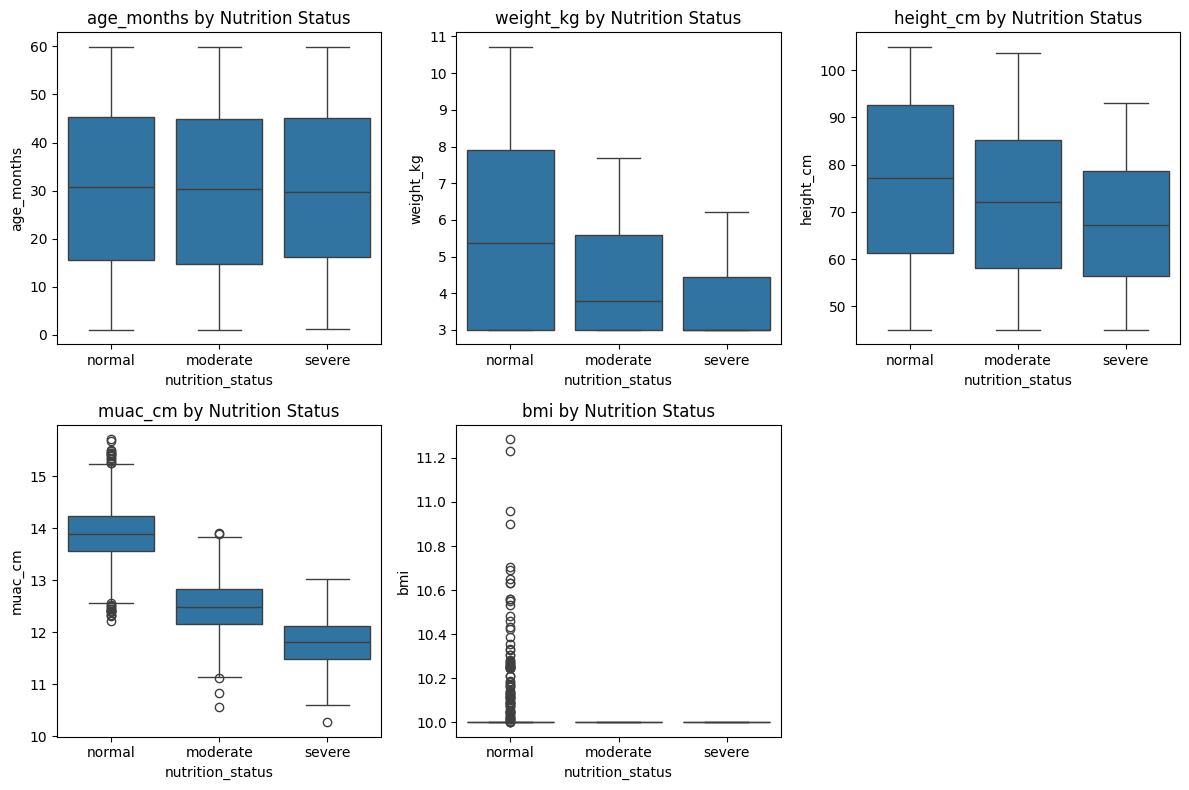

In [ ]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='nutrition_status', y=col, data=df)
    plt.title(f'{col} by Nutrition Status')
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
# Preprocessing
def preprocess_data(df):
    """Preprocess malnutrition dataset"""
    # Encode target variable
    le = LabelEncoder()
    df['nutrition_status'] = le.fit_transform(df['nutrition_status'])

    # Separate features and target
    X = df.drop('nutrition_status', axis=1)
    y = df['nutrition_status']

    # Split data (70% train, 15% validation, 15% test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler for later use
    joblib.dump(scaler, 'scaler.pkl')

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, le

# Preprocess data
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = preprocess_data(df.copy())

## 2. Model Architecture and Implementations
### 2.1 Classical ML Algorithm (SVM with Hyperparameter Tuning)

In [ ]:
def train_svm_model(X_train, y_train, X_val, y_val):
    """Train and tune SVM model"""
    print("\n===== Training SVM Model =====")

    # Hyperparameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly']
    }

    # Create SVM model
    svm = SVC(probability=True, random_state=42)

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )

    # Fit model
    grid_search.fit(X_train, y_train)

    # Best model
    best_svm = grid_search.best_estimator_

    # Evaluate on validation set
    val_pred = best_svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    return best_svm

# Train SVM model
svm_model = train_svm_model(X_train, y_train, X_val, y_val)

os.makedirs('saved_models', exist_ok=True)

# Save model
joblib.dump(svm_model, 'saved_models/svm_tuned.pkl')


===== Training SVM Model =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Accuracy: 0.9613


['saved_models/svm_tuned.pkl']

### 2.2 Simple Neural Network (No Optimization)


===== Training Simple Neural Network =====
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3840 - loss: 1.0986 - val_accuracy: 0.7093 - val_loss: 0.8244
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7049 - loss: 0.7733 - val_accuracy: 0.7373 - val_loss: 0.5875
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7469 - loss: 0.5535 - val_accuracy: 0.8533 - val_loss: 0.4191
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8611 - loss: 0.4091 - val_accuracy: 0.8840 - val_loss: 0.3371
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8734 - loss: 0.3425 - val_accuracy: 0.8827 - val_loss: 0.2999
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8757 - loss: 0.3099 - val_accuracy: 0.8867 - val_loss: 0.2783
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8787 - loss: 0.2894 - val_accuracy: 0.8920 - val_loss: 0.2630
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.2739 - val_accuracy: 0.8947 - val_

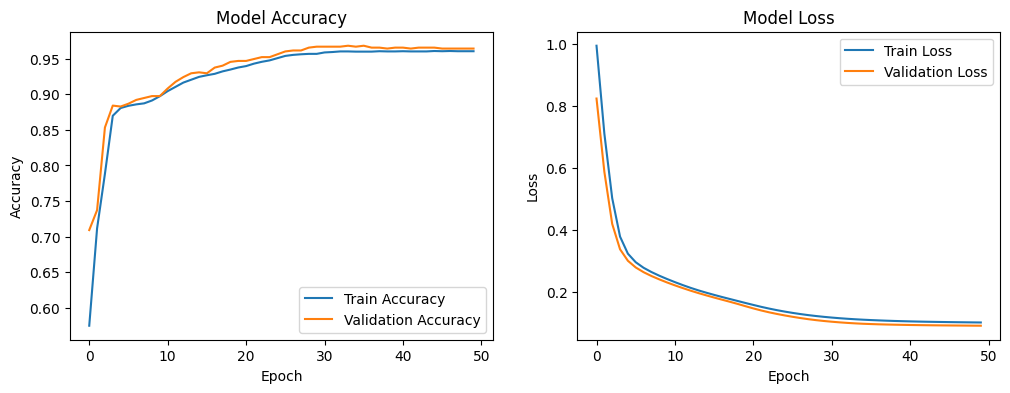

In [ ]:
def build_simple_nn(input_shape, num_classes):
    """Build simple neural network without optimization"""
    model = Sequential([
        # Input layer (5 features)
        Dense(64, activation='relu', input_shape=(input_shape,)),

        # Hidden layers (3 layers with >8 neurons)
        Dense(64, activation='relu'),  # Layer 1
        Dense(32, activation='relu'),  # Layer 2
        Dense(16, activation='relu'),  # Layer 3

        # Output layer (3 classes)
        Dense(num_classes, activation='softmax')
    ])

    # Compile with SGD optimizer (default parameters)
    model.compile(
        optimizer='sgd',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_simple_nn(X_train, y_train, X_val, y_val, epochs=50):
    """Train simple neural network"""
    print("\n===== Training Simple Neural Network =====")

    # Build model
    model = build_simple_nn(X_train.shape[1], len(np.unique(y_train)))

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model

# Train simple neural network
simple_nn = train_simple_nn(X_train, y_train, X_val, y_val)

# Save model
save_model(simple_nn, 'saved_models/simple_nn.h5')

### 2.3 Optimized Neural Network (4 Instances)


===== Training Optimized NN Instance 1 =====
Configuration: {'instance': 1, 'optimizer': 'sgd', 'learning_rate': 0.01, 'regularizer': None, 'regularizer_name': 'None', 'reg_strength': 0.0, 'dropout_rate': 0.0, 'layers': [64, 64, 32, 16], 'epochs': 50, 'early_stopping': False}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_107 (Dense)               │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,203 (28.14 KB)

 Trainable params: 7,203 (28.14 KB)

 Non-trainable params: 0 (0.00 B)

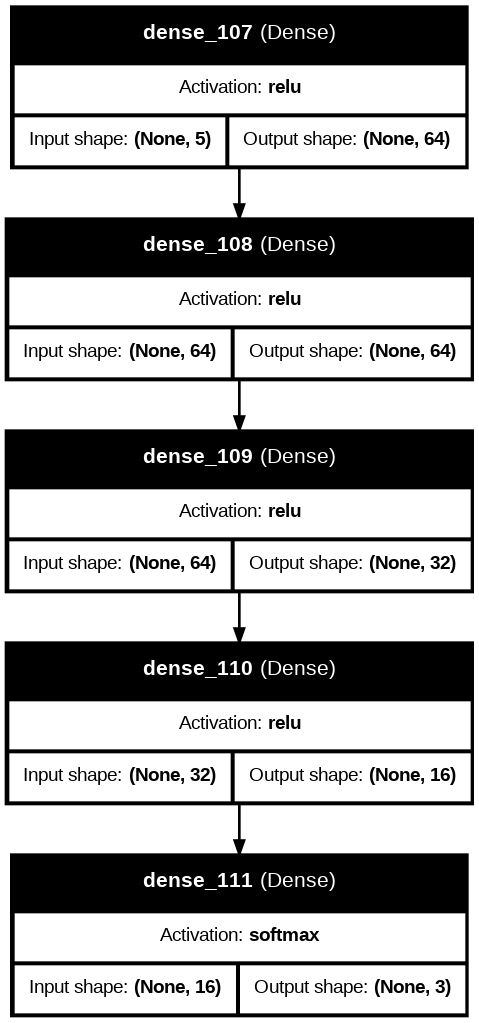

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6596 - loss: 0.9303 - val_accuracy: 0.7093 - val_loss: 0.6493
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7080 - loss: 0.6181 - val_accuracy: 0.7613 - val_loss: 0.4708
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8116 - loss: 0.4482 - val_accuracy: 0.8667 - val_loss: 0.3521
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3478 - val_accuracy: 0.8827 - val_loss: 0.3011
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8766 - loss: 0.3071 - val_accuracy: 0.8853 - val_loss: 0.2776
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8790 - loss: 0.2860 - val_accuracy: 0.8880 - val_loss: 0.2616
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8801 - loss: 0.2702 - val_accuracy: 0.8933 - val_loss: 0.2484
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8815 - loss: 0.2566 - val_accuracy: 0.

Validation Accuracy: 0.9600
F1 Score: 0.9603
Precision: 0.9617
Recall: 0.9600

===== Training Optimized NN Instance 2 =====
Configuration: {'instance': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'regularizer': <class 'keras.src.regularizers.regularizers.L2'>, 'regularizer_name': 'L2', 'reg_strength': 0.01, 'dropout_rate': 0.2, 'layers': [128, 128, 64, 32, 16], 'epochs': 100, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,195 (110.14 KB)

 Trainable params: 28,195 (110.14 KB)

 Non-trainable params: 0 (0.00 B)

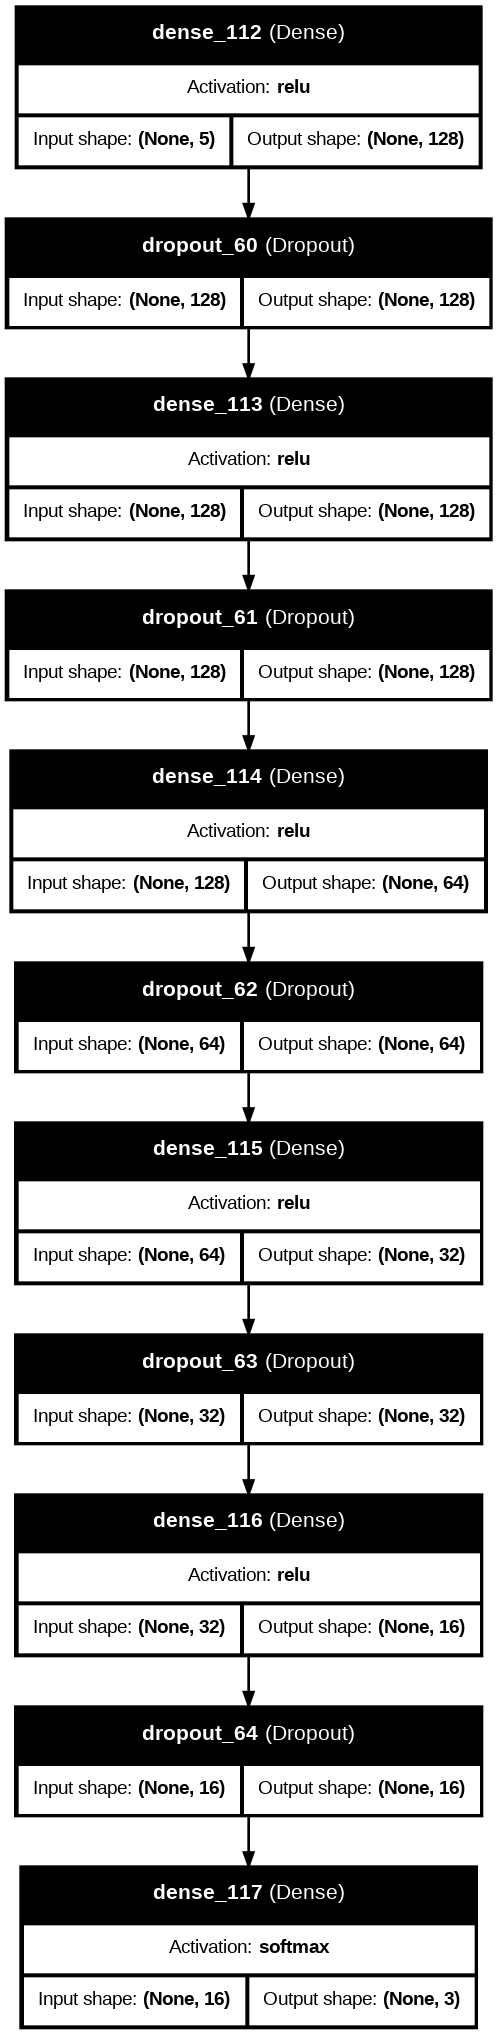

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7030 - loss: 2.8641 - val_accuracy: 0.8907 - val_loss: 1.1149
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8638 - loss: 0.9742 - val_accuracy: 0.8933 - val_loss: 0.5841
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8749 - loss: 0.5959 - val_accuracy: 0.9013 - val_loss: 0.4378
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8865 - loss: 0.4606 - val_accuracy: 0.9080 - val_loss: 0.3790
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8872 - loss: 0.4217 - val_accuracy: 0.9080 - val_loss: 0.3524
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8920 - loss: 0.3917 - val_accuracy: 0.9080 - val_loss: 0.3367
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8999 - loss: 0.3783 - val_accuracy: 0.9053 - val_loss: 0.3228
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8882 - loss: 0.3738 - val_accu

Validation Accuracy: 0.9640
F1 Score: 0.9639
Precision: 0.9642
Recall: 0.9640

===== Training Optimized NN Instance 3 =====
Configuration: {'instance': 3, 'optimizer': 'rmsprop', 'learning_rate': 0.01, 'regularizer': <class 'keras.src.regularizers.regularizers.L1'>, 'regularizer_name': 'L1', 'reg_strength': 0.001, 'dropout_rate': 0.3, 'layers': [256, 128, 64, 32, 16], 'epochs': 150, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,347 (177.14 KB)

 Trainable params: 45,347 (177.14 KB)

 Non-trainable params: 0 (0.00 B)

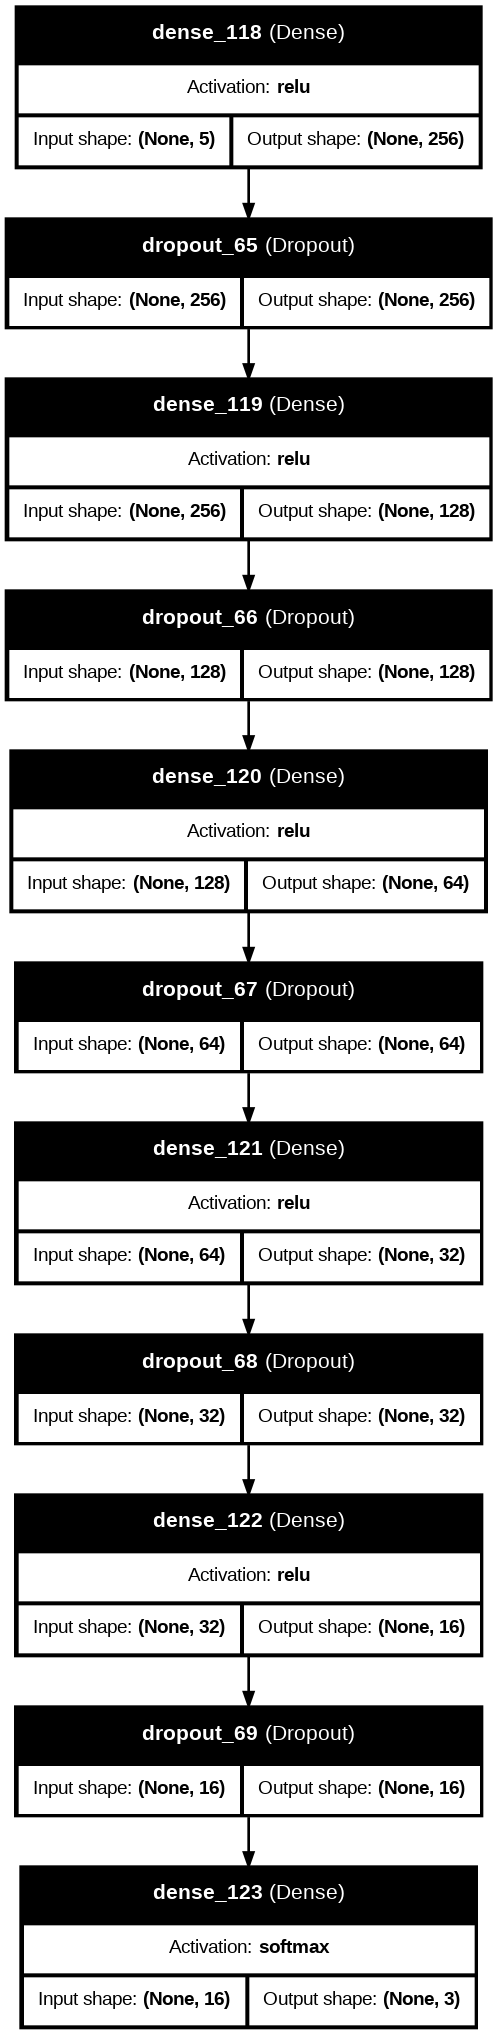

Epoch 1/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7913 - loss: 1.4752 - val_accuracy: 0.8653 - val_loss: 0.6444
Epoch 2/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8782 - loss: 0.6406 - val_accuracy: 0.8933 - val_loss: 0.5670
Epoch 3/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8793 - loss: 0.6137 - val_accuracy: 0.8920 - val_loss: 0.5487
Epoch 4/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8908 - loss: 0.5713 - val_accuracy: 0.9067 - val_loss: 0.5076
Epoch 5/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8872 - loss: 0.5713 - val_accuracy: 0.8987 - val_loss: 0.4992
Epoch 6/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8926 - loss: 0.5576 - val_accuracy: 0.9013 - val_loss: 0.5355
Epoch 7/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8898 - loss: 0.5663 - val_accuracy: 0.9267 - val_loss: 0.5013
Epoch 8/150
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8994 - loss: 0.5572 - val_accu

Validation Accuracy: 0.9573
F1 Score: 0.9561
Precision: 0.9570
Recall: 0.9573

===== Training Optimized NN Instance 4 =====
Configuration: {'instance': 4, 'optimizer': 'adam', 'learning_rate': 0.0005, 'regularizer': <class 'keras.src.regularizers.regularizers.L2'>, 'regularizer_name': 'L2', 'reg_strength': 0.001, 'dropout_rate': 0.4, 'layers': [256, 256, 128, 64, 32, 16], 'epochs': 200, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_124 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,139 (434.14 KB)

 Trainable params: 111,139 (434.14 KB)

 Non-trainable params: 0 (0.00 B)

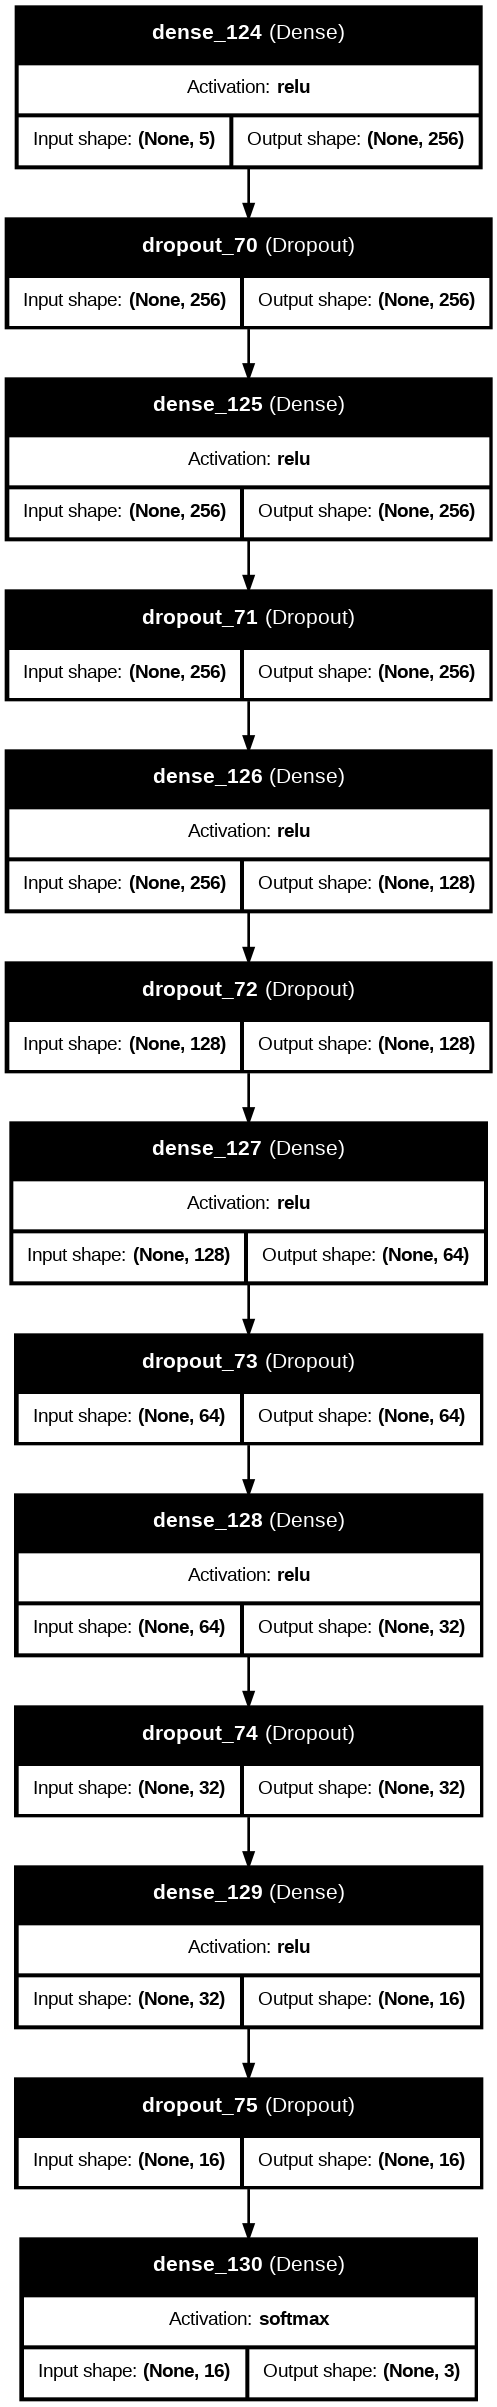

Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5944 - loss: 1.4746 - val_accuracy: 0.7093 - val_loss: 0.9080
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7194 - loss: 0.9681 - val_accuracy: 0.8853 - val_loss: 0.8145
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8239 - loss: 0.8460 - val_accuracy: 0.8893 - val_loss: 0.7361
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8640 - loss: 0.7522 - val_accuracy: 0.8973 - val_loss: 0.6450
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8808 - loss: 0.6698 - val_accuracy: 0.9053 - val_loss: 0.5485
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8862 - loss: 0.6028 - val_accuracy: 0.9067 - val_loss: 0.4913
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8901 - loss: 0.5337 - val_accuracy: 0.9107 - val_loss: 0.4539
Epoch 8/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8949 - loss: 0.5064 - val_acc

Validation Accuracy: 0.9667
F1 Score: 0.9665
Precision: 0.9665
Recall: 0.9667

===== Training Optimized NN Instance 5 =====
Configuration: {'instance': 5, 'optimizer': 'rmsprop', 'learning_rate': 0.005, 'regularizer': None, 'regularizer_name': 'None', 'reg_strength': 0.0, 'dropout_rate': 0.25, 'layers': [192, 96, 48, 24], 'epochs': 100, 'early_stopping': True}

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_131 (Dense)               │ (None, 192)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,587 (99.95 KB)

 Trainable params: 25,587 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

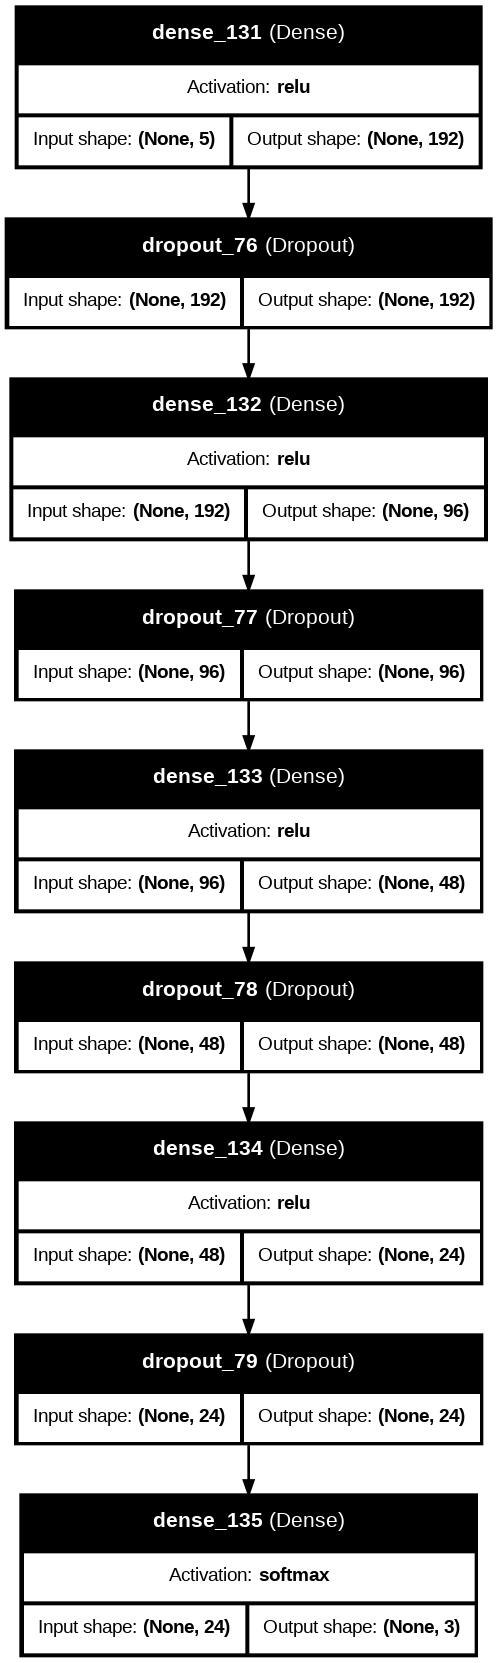

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8181 - loss: 0.4330 - val_accuracy: 0.8933 - val_loss: 0.1916
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9180 - loss: 0.2012 - val_accuracy: 0.9507 - val_loss: 0.1188
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9379 - loss: 0.1626 - val_accuracy: 0.9573 - val_loss: 0.1084
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9403 - loss: 0.1569 - val_accuracy: 0.9400 - val_loss: 0.1212
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9424 - loss: 0.1439 - val_accuracy: 0.9600 - val_loss: 0.1034
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9430 - loss: 0.1489 - val_accuracy: 0.9667 - val_loss: 0.0847
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9475 - loss: 0.1406 - val_accuracy: 0.9587 - val_loss: 0.1080
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9485 - loss: 0.1330 - val_accu

Validation Accuracy: 0.9707
F1 Score: 0.9699
Precision: 0.9709
Recall: 0.9707

Optimized Neural Network Results:


,instance,optimizer,regularizer,epochs,early_stopping,layers,learning_rate,dropout_rate,accuracy,f1_score,precision,recall,val_loss
0,1,sgd,None,50,False,4,0.0100,0.00,0.960000,0.960270,0.961673,0.960000,0.092799
1,2,adam,L2,34,True,5,0.0010,0.20,0.964000,0.963864,0.964203,0.964000,0.225716
2,3,rmsprop,L1,30,True,5,0.0100,0.30,0.957333,0.956091,0.956965,0.957333,0.418248
3,4,adam,L2,46,True,6,0.0005,0.40,0.966667,0.966458,0.966471,0.966667,0.144362
4,5,rmsprop,None,18,True,4,0.0050,0.25,0.970667,0.969878,0.970866,0.970667,0.080405


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model # Import save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2 # Import L1 and L2 regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
from IPython.display import Image

def visualize_model_architecture(model, filename=None):
    """Visualize the neural network architecture"""
    print("\nModel Architecture:")
    model.summary()

    # Plot model diagram
    tf.keras.utils.plot_model(
        model,
        to_file=filename,
        show_shapes=True,
        show_layer_names=True,
        show_layer_activations=True,
        rankdir='TB',
        dpi=96
    )

    if filename:
        display(Image(filename))


def build_optimized_nn(input_shape, num_classes,
                      optimizer='adam', learning_rate=0.001,
                      regularizer=None, reg_strength=0.01,
                      dropout_rate=0.0, layers=[128, 64, 32]):
    """Build optimized neural network with configurable parameters"""
    model = Sequential()

    # Input layer (5 features)
    model.add(Dense(layers[0], activation='relu',
                  input_shape=(input_shape,),
                  kernel_regularizer=regularizer(reg_strength) if regularizer else None))

    # Add dropout if specified
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Add hidden layers (minimum 3 layers)
    for units in layers[1:]:
        model.add(Dense(units, activation='relu',
                      kernel_regularizer=regularizer(reg_strength) if regularizer else None))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer (3 classes)
    model.add(Dense(num_classes, activation='softmax'))

    # Configure optimizer
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # Default to SGD
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_optimized_nn(instance_config, X_train, y_train, X_val, y_val):
    """Train optimized neural network with specific configuration"""
    print(f"\n===== Training Optimized NN Instance {instance_config['instance']} =====")
    print(f"Configuration: {instance_config}")

    # Build model
    model = build_optimized_nn(
        input_shape=X_train.shape[1],
        num_classes=len(np.unique(y_train)),
        optimizer=instance_config['optimizer'],
        learning_rate=instance_config['learning_rate'],
        regularizer=instance_config['regularizer'],
        reg_strength=instance_config['reg_strength'],
        dropout_rate=instance_config['dropout_rate'],
        layers=instance_config['layers']
    )

    # Visualize architecture for this instance
    visualize_model_architecture(model, f'optimized_nn_inst{instance_config["instance"]}_architecture.png')


    # Set up callbacks
    callbacks = []
    if instance_config['early_stopping']:
        callbacks.append(EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ))

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=instance_config['epochs'],
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Save model
    model_path = f"saved_models/optimized_nn_inst{instance_config['instance']}.h5"
    save_model(model, model_path)

    # Return results
    return {
        'instance': instance_config['instance'],
        'optimizer': instance_config['optimizer'],
        'regularizer': instance_config['regularizer_name'],
        'epochs': len(history.history['loss']),
        'early_stopping': instance_config['early_stopping'],
        'layers': len(instance_config['layers']),
        'learning_rate': instance_config['learning_rate'],
        'dropout_rate': instance_config['dropout_rate'],
        'accuracy': val_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'val_loss': val_loss # Added loss to results for the README
    }

# Define configurations for 5 instances
optimized_nn_configs = [
    {  # Instance 1: Baseline (no optimization techniques)
        'instance': 1,
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'regularizer': None,
        'regularizer_name': 'None',
        'reg_strength': 0.0,
        'dropout_rate': 0.0,
        'layers': [64, 64, 32, 16],  # 4 hidden layers
        'epochs': 50,
        'early_stopping': False
    },
    {  # Instance 2: Adam optimizer, L2 regularization, early stopping
        'instance': 2,
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'regularizer': l2,
        'regularizer_name': 'L2',
        'reg_strength': 0.01,
        'dropout_rate': 0.2,
        'layers': [128, 128, 64, 32, 16],  # 5 hidden layers
        'epochs': 100,
        'early_stopping': True
    },
    {  # Instance 3: RMSprop optimizer, L1 regularization, dropout
        'instance': 3,
        'optimizer': 'rmsprop',
        'learning_rate': 0.01,
        'regularizer': l1,
        'regularizer_name': 'L1',
        'reg_strength': 0.001,
        'dropout_rate': 0.3,
        'layers': [256, 128, 64, 32, 16],  # 5 hidden layers
        'epochs': 150,
        'early_stopping': True
    },
    {  # Instance 4: Adam optimizer, L2 regularization, higher dropout
        'instance': 4,
        'optimizer': 'adam',
        'learning_rate': 0.0005,
        'regularizer': l2,
        'regularizer_name': 'L2',
        'reg_strength': 0.001,
        'dropout_rate': 0.4,
        'layers': [256, 256, 128, 64, 32, 16],  # 6 hidden layers
        'epochs': 200,
        'early_stopping': True
    },
    {   # Instance 5: RMSprop optimizer, no regularization, moderate dropout
        'instance': 5,
        'optimizer': 'rmsprop',
        'learning_rate': 0.005,
        'regularizer': None,
        'regularizer_name': 'None',
        'reg_strength': 0.0,
        'dropout_rate': 0.25,
        'layers': [192, 96, 48, 24], # 4 hidden layers
        'epochs': 100,
        'early_stopping': True
    }
]
# Train all optimized NN instances
results_table = []
for config in optimized_nn_configs:
    result = train_optimized_nn(config, X_train, y_train, X_val, y_val)
    results_table.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results_table)
print("\nOptimized Neural Network Results:")
display(results_df)

### 2.4 XGBoost with Hyperparameter Tuning

In [ ]:
def train_xgboost_model(X_train, y_train, X_val, y_val):
    """Train and tune XGBoost model"""
    print("\n===== Training XGBoost Model =====")

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Create XGBoost model
    xgb = XGBClassifier(
        objective='multi:softmax',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )

    # Fit model
    grid_search.fit(X_train, y_train)

    # Best model
    best_xgb = grid_search.best_estimator_

    # Evaluate on validation set
    val_pred = best_xgb.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    return best_xgb

# Train XGBoost model
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)

# Save model
joblib.dump(xgb_model, 'saved_models/xgboost_tuned.pkl')


===== Training XGBoost Model =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Validation Accuracy: 0.9520


['saved_models/xgboost_tuned.pkl']

## 3. Model Evaluation on Test Data

In [ ]:
# Load the saved models
svm_model_loaded = joblib.load('saved_models/svm_tuned.pkl')
simple_nn_loaded = tf.keras.models.load_model('saved_models/simple_nn.h5')
xgboost_model_loaded = joblib.load('saved_models/xgboost_tuned.pkl')

# Load optimized NN models
optimized_nn_models_loaded = {}
for i in range(1, 6):
    try:
        model_path = f"saved_models/optimized_nn_inst{i}.h5"
        optimized_nn_models_loaded[f'instance_{i}'] = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Could not load optimized NN instance {i}: {e}")

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    """Evaluates a trained model on the test set and prints metrics."""
    print(f"\n===== Evaluating {model_name} =====")

    if isinstance(model, tf.keras.Model):
        # Neural Network evaluation
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        # Scikit-learn model evaluation
        accuracy = model.score(X_test, y_test)
        y_pred = model.predict(X_test)

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(class_report)

    # Store results
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score (weighted)': f1,
        'Precision (weighted)': precision,
        'Recall (weighted)': recall
    }

# Evaluate models on test data
test_results = []

# Evaluate SVM
test_results.append(evaluate_model(svm_model_loaded, X_test, y_test, "SVM (Tuned)", label_encoder))

# Evaluate Simple NN
test_results.append(evaluate_model(simple_nn_loaded, X_test, y_test, "Simple NN (No Optimization)", label_encoder))

# Evaluate Optimized NNs
for name, model in optimized_nn_models_loaded.items():
     test_results.append(evaluate_model(model, X_test, y_test, f"Optimized NN ({name})", label_encoder))

# Evaluate XGBoost
test_results.append(evaluate_model(xgboost_model_loaded, X_test, y_test, "XGBoost (Tuned)", label_encoder))

# Display test results in a DataFrame
test_results_df = pd.DataFrame(test_results)
print("\n===== Test Set Evaluation Results =====")
display(test_results_df)


===== Evaluating SVM (Tuned) =====
Accuracy: 0.9720
F1 Score (weighted): 0.9717
Precision (weighted): 0.9717
Recall (weighted): 0.9720

Confusion Matrix:
[[151  10   4]
 [  2 531   0]
 [  5   0  47]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.96      0.92      0.93       165
      normal       0.98      1.00      0.99       533
      severe       0.92      0.90      0.91        52

    accuracy                           0.97       750
   macro avg       0.95      0.94      0.95       750
weighted avg       0.97      0.97      0.97       750


===== Evaluating Simple NN (No Optimization) =====
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9667
F1 Score (weighted): 0.9666
Precision (weighted): 0.9666
Recall (weighted): 0.9667

Confusion Matrix:
[[151   8   6]
 [  6 527   0]
 [  5   0  47]]

Classification Report:
              precision    recall  f1-score   support

    moderate       0.93      0.92      0.92       165
     

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(column, errors="raise")


,Model,Accuracy,F1 Score (weighted),Precision (weighted),Recall (weighted)
0,SVM (Tuned),0.972000,0.971698,0.971679,0.972000
1,Simple NN (No Optimization),0.966667,0.966601,0.966586,0.966667
2,Optimized NN (instance_1),0.964000,0.963789,0.963842,0.964000
3,Optimized NN (instance_2),0.965333,0.965187,0.965163,0.965333
4,Optimized NN (instance_3),0.952000,0.949876,0.952970,0.952000
5,Optimized NN (instance_4),0.958667,0.957529,0.958957,0.958667
6,Optimized NN (instance_5),0.954667,0.951992,0.956989,0.954667
7,XGBoost (Tuned),0.961333,0.960808,0.960560,0.961333


In [ ]:
# Identify the best performing model based on Accuracy on the test set
best_model_row = test_results_df.loc[test_results_df['Accuracy'].idxmax()]
best_model_name = best_model_row['Model']

print(f"\nBest performing model on the test set is: {best_model_name}")
display(best_model_row)

# You can then save the best model if needed (assuming the model objects are still in memory or can be reloaded)
# For example, if the best model is SVM:
if best_model_name == "SVM (Tuned)":
    # The SVM model is already loaded as svm_model_loaded
    # joblib.dump(svm_model_loaded, 'best_model.pkl') # Uncomment to save
    print("\nSVM model is the best and is already saved as 'saved_models/svm_tuned.pkl'")

# If the best model is one of the Optimized NNs:
elif "Optimized NN" in best_model_name:
    instance_num = int(best_model_name.split('_')[-1].replace(')', ''))
    model_key = f'instance_{instance_num}'
    if model_key in optimized_nn_models_loaded:
        best_nn_model = optimized_nn_models_loaded[model_key]
        # best_nn_model.save('best_model.h5') # Uncomment to save
        print(f"\nOptimized NN ({model_key}) is the best. It is already saved as 'saved_models/optimized_nn_inst{instance_num}.h5'")

# If the best model is Simple NN:
elif best_model_name == "Simple NN (No Optimization)":
    # The Simple NN model is already loaded as simple_nn_loaded
    # simple_nn_loaded.save('best_model.h5') # Uncomment to save
     print("\nSimple NN model is the best and is already saved as 'saved_models/simple_nn.h5'")

# If the best model is XGBoost:
elif best_model_name == "XGBoost (Tuned)":
    # The XGBoost model is already loaded as xgboost_model_loaded
    # joblib.dump(xgboost_model_loaded, 'best_model.pkl') # Uncomment to save
    print("\nXGBoost model is the best and is already saved as 'saved_models/xgboost_tuned.pkl'")


Best performing model on the test set is: SVM (Tuned)


,0
Model,SVM (Tuned)
Accuracy,0.972
F1 Score (weighted),0.971698
Precision (weighted),0.971679
Recall (weighted),0.972



SVM model is the best and is already saved as 'saved_models/svm_tuned.pkl'


## 5. Conclusion and Summary of Findings

Based on the test set evaluation, the **SVM (Tuned)** model achieved the highest accuracy of **0.9720**. It also demonstrated strong performance across other metrics like F1-score, precision, and recall, indicating its effectiveness in classifying malnutrition statuses.

The optimized neural network models, while showing promising results during validation, had slightly lower performance on the unseen test data compared to the tuned SVM. Optimized NN Instance 2 and Simple NN (No Optimization) performed comparably to XGBoost, while Optimized NN Instances 1, 3, 4, and 5 had slightly lower accuracy on the test set.

The confusion matrices and classification reports provide a more detailed view of each model's performance on each class (moderate, normal, severe). This information can be used to understand where each model excels and where there might be areas for improvement, especially concerning the less represented classes like 'severe' malnutrition.

Overall, the **SVM (Tuned)** model is the best performing model on this dataset for this classification task based on the evaluation metrics.